#### Includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import torch.nn.functional as F
import altair as alt
from altair import datum
import pandas as pd

import sys
sys.path.insert(0, '../')

In [3]:
from src.rot_utils import *
from src.steered_cnn import SteerableKernelBase
from src.model import HemelingRotNet
from src.utils import *

## Spatial Homogeneity

In [4]:
base = SteerableKernelBase.create_from_rk(4, max_k=5)
K1 = torch.randn((2000,1,5,5))
W = base.approximate_weights(K1)

In [5]:
w_df = pd.DataFrame(data=base.weights_dist(W))
w_df

,r,k,type,name,median,q0,-q0,q1,-q1,q2,-q2
0,0,0,R,"r=0, k=0, Real",-2.616273e+10,3.370578e+14,-1.005004e+15,9.376516e+12,-2.705028e+13,-2.616273e+10,-2.616273e+10
1,1,0,R,"r=1, k=0, Real",-1.510002e+15,1.465747e+20,-1.232843e+20,6.546103e+18,-7.292922e+18,-1.510002e+15,-1.510002e+15
2,2,0,R,"r=2, k=0, Real",-5.074771e+15,9.793572e+19,-1.300138e+20,7.315043e+18,-7.175789e+18,-5.074771e+15,-5.074771e+15
3,3,0,R,"r=3, k=0, Real",3.216529e+17,1.447046e+20,-5.135521e+19,1.155132e+19,-2.034407e+18,3.216529e+17,3.216529e+17
4,1,1,R,"r=1, k=1, Real",6.373686e+16,1.363092e+20,-1.015662e+20,1.193686e+19,-4.505166e+18,6.373686e+16,6.373686e+16
5,1,1,I,"r=1, k=1, Imag",-4.427522e+16,1.255930e+20,-1.469077e+20,5.684619e+18,-9.868850e+18,-4.427522e+16,-4.427522e+16
6,2,1,R,"r=2, k=1, Real",1.166473e+15,1.420302e+20,-1.648954e+20,1.020760e+19,-1.456274e+19,1.166473e+15,1.166473e+15
7,2,1,I,"r=2, k=1, Imag",-6.261758e+16,1.223114e+20,-1.343071e+20,7.313661e+18,-1.207156e+19,-6.261758e+16,-6.261758e+16
8,3,1,R,"r=3, k=1, Real",-4.374407e+16,8.802623e+19,-1.501024e+20,5.884565e+18,-1.169872e+19,-4.374407e+16,-4.374407e+16
9,3,1,I,"r=3, k=1, Imag",4.294197e+17,2.070809e+20,-6.509748e+19,1.941971e+19,-3.529180e+18,4.294197e+17,4.294197e+17


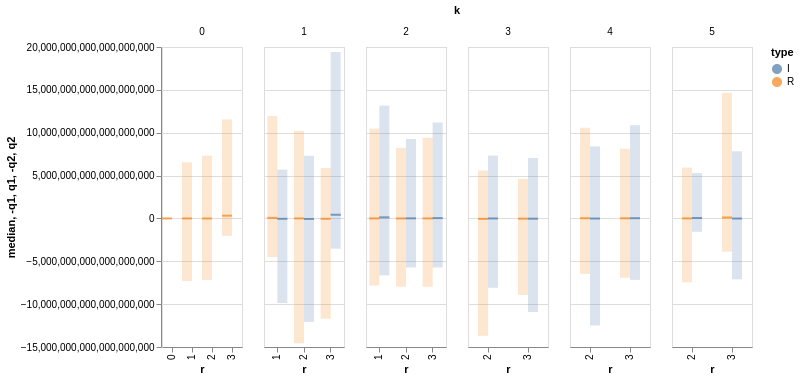

In [6]:
chart = alt.Chart(w_df)
layered = alt.LayerChart()
for real in [True, False]:
    layered += chart.mark_tick(
                        thickness=2,
                        width=10,
                        xOffset=-5 if real else 5
                    ).encode(
                        alt.X('r:N'), alt.Y('median:Q'), 
                        alt.Color('type:N')
                    ).transform_filter(datum.type== ('R' if real else 'I') )
    layered += chart.mark_bar(
                        opacity=.2, 
                        width=10, 
                        xOffset=-5 if real else 5
                 ).encode(
                    alt.X('r:N'), alt.Y('-q1:Q'), alt.Y2('q1:Q'), 
                    alt.Color('type:N')
                  ).properties(width=80).transform_filter(datum.type== ('R' if real else 'I') )
    layered += chart.mark_bar(
                        opacity=.2, 
                        width=10, 
                        xOffset=-5 if real else 5
                 ).encode(
                    alt.X('r:N'), alt.Y('-q2:Q'), alt.Y2('q2:Q'), 
                    alt.Color('type:N')
                  ).properties(width=80).transform_filter(datum.type== ('R' if real else 'I') )
layered.facet('k:O').resolve_scale(x='independent').interactive()

/home/gaby/.conda/envs/nnet/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


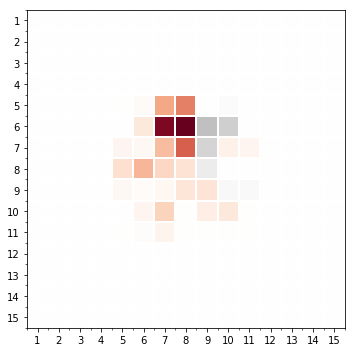

In [7]:
h, w = 15, 15
I = torch.zeros((1,1,h,w))
I[0,0,h//2,w//2] = 1
W1 = torch.ones(W.shape)
plot_filter(base.conv2d(I, W1)[0,0])

In [8]:
O = base.conv2d(I, W1)[0,0]
O.max()

tensor(5.8699)

## Variance conservation

In [61]:
net = HemelingRotNet(1, 1, padding='auto').cuda()

In [62]:
forward_tensors = {}
backward_tensors = {}

def store_forward(name):
    def hook(self, input, output):
        forward_tensors[name+'-in'] = input
        forward_tensors[name+'-out'] = output
    return hook

def store_backward(name):
    def hook(self, grad_input, grad_output):
        backward_tensors[name+'-in'] = grad_input
        backward_tensors[name+'-out'] = grad_output
    return hook

for i in range(1,9):
    name = f'conv{i}'
    getattr(net, name)[0].register_forward_hook(store_forward(name))
    getattr(net, name)[0].register_backward_hook(store_backward(name))

In [63]:
I = torch.randn((5,1,500,500)).cuda()
angle = (torch.rand((5,500,500)).cuda()-.5)*2*np.pi
out = net(I, alpha=angle)
loss = F.binary_cross_entropy_with_logits(out, torch.randint(1, (5,1,496,496)).float().cuda())
loss.backward()

In [64]:
data = []
for i in range(1,9):
    name = f'conv{i}'
    for input in [True, False]:
        d = {}
        d['name'] = name
        d['type'] = 'in' if input else 'out'
        
        n = name + ('-in' if input else '-out')
        forward = forward_tensors[n][0].detach()
        backward = backward_tensors[n][0].detach()
        
        mean = forward.mean().cpu().numpy()
        std = forward.std().cpu().numpy()
        d['forward_mean'] = mean
        d['forward_y'] = mean-std
        d['forward_y2'] = mean+std
        
        mean = backward.mean().cpu().numpy()
        std = backward.std().cpu().numpy()
        d['backward_mean'] = mean
        d['backward_y'] = mean-std
        d['backward_y2'] = mean+std
        
        data += [d]
dist_df = pd.DataFrame(data=data)


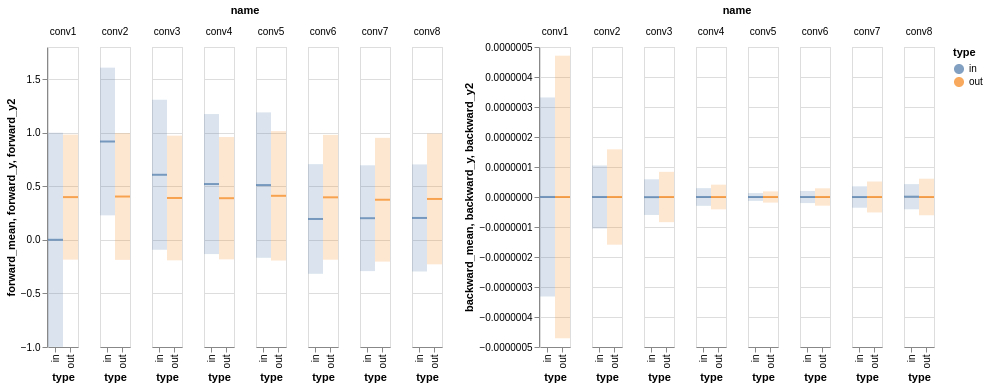

In [66]:
chart = alt.Chart(dist_df)
def plot_dist(back=False):
    n = 'forward_' if not back else 'backward_'
    layered = alt.LayerChart()
    layered += chart.mark_tick(
                        thickness=2,
                        width=15,
                    ).encode(
                        alt.X('type:N'), alt.Y(n+'mean:Q'), 
                        alt.Color('type:N')
                    )
    layered += chart.mark_bar(
                        opacity=.2, 
                        width=15,
                 ).encode(
                    alt.X('type:N'), alt.Y(n+'y:Q'), alt.Y2(n+'y2:Q'), 
                    alt.Color('type:N')
                  ).properties(width=30)
    return layered.facet('name:O').resolve_scale(x='independent').interactive()
    
(plot_dist(False)|plot_dist(True))